In [2]:
from pyspark.sql import SparkSession

MAX_MEMORY = "5g"
spark = SparkSession.builder.master("local")\
                    .appName("ml_taix")\
                    .config("spark.excutor.memory", MAX_MEMORY)\
                    .config("spark.driver.memory", MAX_MEMORY).getOrCreate()

23/02/13 17:08:32 WARN Utils: Your hostname, imhaneul-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 172.30.1.71 instead (on interface en0)
23/02/13 17:08:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/13 17:08:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import os 

trip_data = f"{os.getcwd()}/data/2020"
trip_directory = spark.read.parquet(f"file:///{trip_data}/*")
trip_directory.createOrReplaceTempView("trips")

In [4]:
trip_directory.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp (nullable = true)
 |-- on_scene_datetime: timestamp (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_flag: string (nul

In [5]:
qs = """
SELECT
    pickup_datetime,
    PULocationID as pickup_location_id,
    DOLocationID as drop_location_id,
    tips,
    driver_pay,
    trip_miles,
    trip_time
FROM 
    trips
"""
spark.sql(qs).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|pickup_location_id|  drop_location_id|              tips|        driver_pay|        trip_miles|         trip_time|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|         143309871|         143309871|         143309871|         143309871|         143309871|         143309871|
|   mean|135.92875505414418|139.09949075315265|0.5364331266482734|14.211915859793367|4.6088413219490825|1018.6358777268036|
| stddev|   76.273342419336| 78.33690451151065| 2.018249850934298|12.110340608087894| 5.182921839431114| 689.3967862882561|
|    min|                 1|                 1|               0.0|           -273.08|               0.0|                 0|
|    max|               265|               265|             564.0|           4894.62|           1310.51|             85804|
+-------

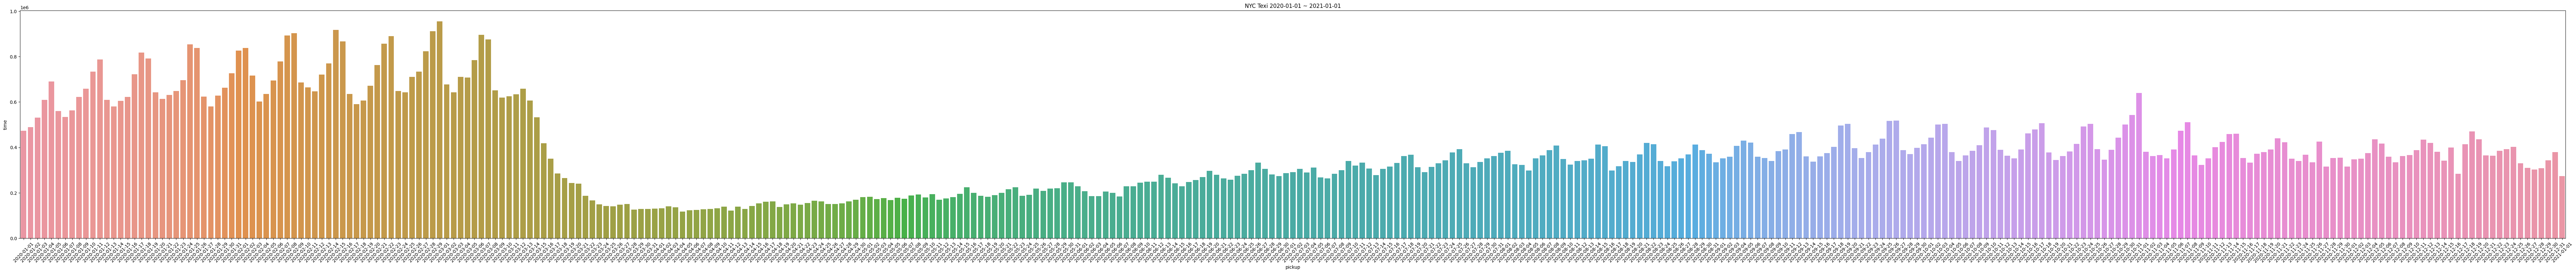

In [6]:
qs = """
SELECT 
    pickup, 
    count(*) as time
FROM
    (SELECT 
        split(pickup_datetime, " ")[0] as pickup
    FROM 
        trips    
    )
GROUP BY 
    pickup
ORDER BY 
    pickup
"""
time_data = spark.sql(qs).toPandas()

import seaborn as sns 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(100, 9))
sns.barplot(x="pickup", y="time", data=time_data)
plt.xticks(rotation=45)
plt.title("NYC Texi 2020-01-01 ~ 2021-01-01")
plt.show()

In [7]:
#trip_data = f"{os.getcwd()}/data/2020"
# trip_directory = spark.read.parquet(f"file:///{trip_data}/*")
# trip_directory.createOrReplaceTempView("trips")
from typing import List

directory: str = [f"{os.getcwd()}/data/{i}" for i in os.listdir(f"{os.getcwd()}/data")][2]
filename: List[str] = [f"{directory}/{data}" for data in os.listdir(directory)]
filename.sort()

In [8]:
filename

['/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-01.parquet',
 '/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-02.parquet',
 '/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-03.parquet',
 '/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-04.parquet',
 '/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-05.parquet',
 '/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-06.parquet',
 '/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-07.parquet',
 '/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-08.parquet',
 '/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2020/fhvhv_tripdata_2020-09.parquet',
 '/Users/imhaneul/D

In [284]:
qs = """
SELECT 
    pickup, 
    count(*) as time
FROM
    (SELECT 
        split(pickup_datetime, " ")[0] as pickup
    FROM 
        trips    
    )
GROUP BY 
    pickup
ORDER BY 
    pickup
"""
from queue import Queue

def year_read_data() -> List:
    return [spark.read.parquet(f"file:///{data}") for data in filename]

def year_data() -> Queue:
    t_pickup_dat = []
    for data in year_read_data():
        data.createOrReplaceTempView("trips")
        td = spark.sql(qs).toPandas()
        t_pickup_dat.append(td)
    return t_pickup_dat

data = year_data()

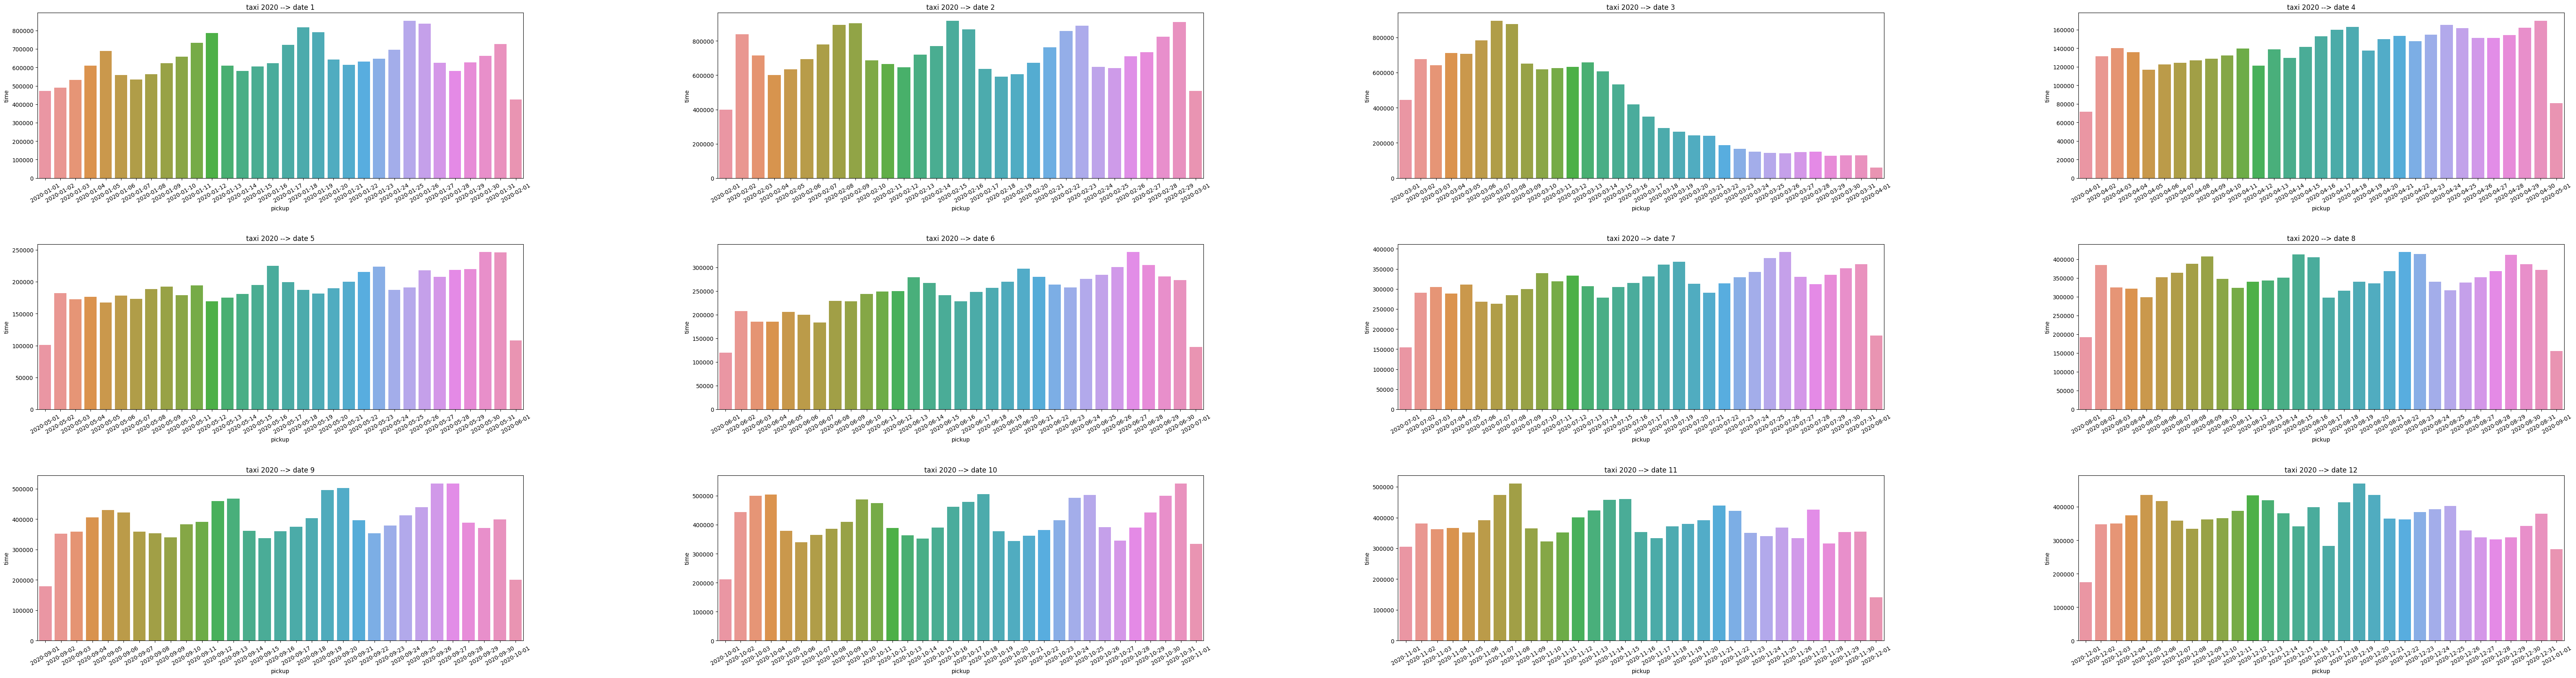

In [317]:
def visualization_shape(data) -> None:
    n_rows = 3
    n_cols = 4
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 10))
    plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
    fig.set_size_inches((80, 20))

    for i, axi in enumerate(ax.flat):
        sns.barplot(x='pickup', y='time', data=data[i], ax=axi)
        axi.set_title(f'taxi 2020 --> date {i+1}')
        axi.set_xticklabels(axi.get_xticklabels(), rotation=30)

    # 데이터 플롯 출력
    plt.show()

visualization_shape(data=data)